In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import datetime as dt
import emcee

from scipy.spatial import Delaunay
from scipy.stats import linregress
from scipy.optimize import curve_fit
from getdist import plots, MCSamples

from qubic.lib.Qgps import GPSAntenna
import qubic.lib.Calibration.Qfiber as ft
 
%matplotlib inline

# Import data

In [2]:
### Build GPS data file path
data_path = "calsource_orientation.dat"

### Define the distance between the two antennas
distance_between_antennas = 1.3

In [3]:
### Build the GPSAntenna instance
gps_antenna = GPSAntenna(data_path, distance_between_antennas)

In [4]:
date = np.array([dt.datetime(year=2024, month=12, day=12, hour=8, minute=55, second=0)])
index_ini = gps_antenna.get_observation_indices(gps_antenna._datetime, date)[0]
print('Initial index = ', index_ini)
print('size observation times : ', len(gps_antenna._datetime))

Initial index =  259100
size observation times :  337192


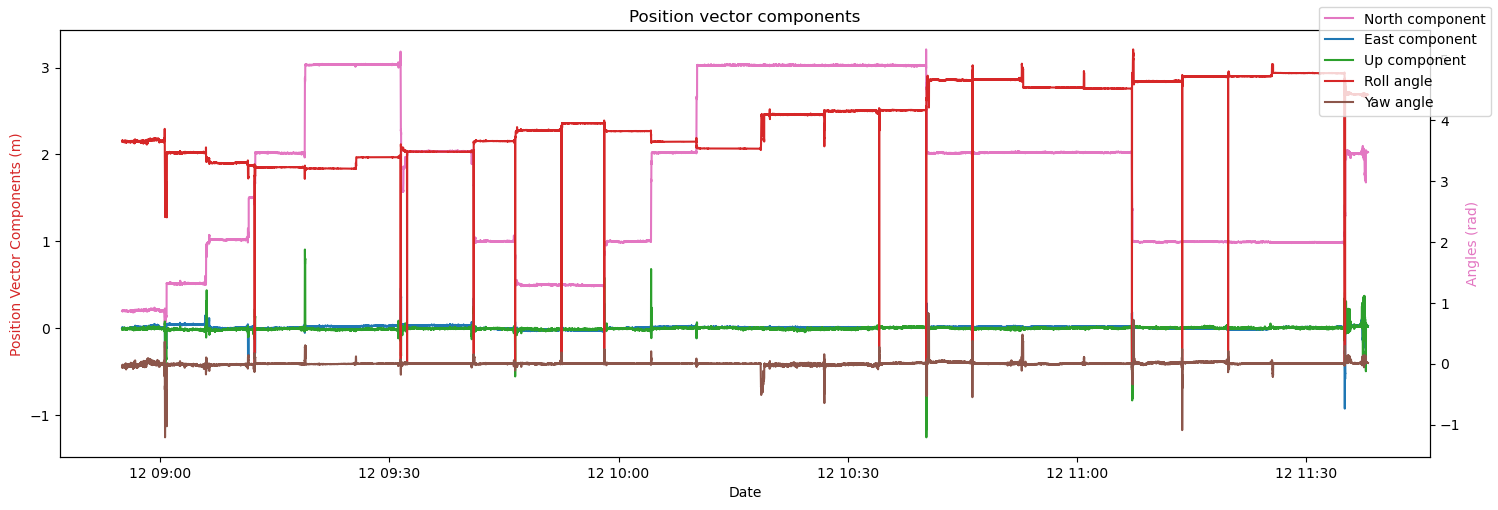

In [5]:
gps_antenna.plot_gps_data(index_start=index_ini)

# Build observation time indices

In [6]:
# Array containing the starting time of each configuration
array_hours = np.array([8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11])
array_minutes_begins = np.array([55, 00, 6, 12, 19, 25, 32, 41, 46, 52, 58, 4, 10, 19, 27, 34, 40, 46, 53, 1, 7, 13, 20, 25])

# Array containing the ending time of each configuration, build by substracting 1 minute to the starting time
# In this case, each time correspond to do the ending time of the previous configuration
array_minutes_ending = array_minutes_begins.copy() - 1
array_minutes_ending[1] = 0

# Array containing the seconds of each configuration
array_seconds_begins = np.ones(array_hours.shape, dtype=int) * 59
array_seconds_ending = np.zeros(array_hours.shape, dtype=int)

# Build the array of datetime associated with each configuration, to delimit the time when the antenna are moving or not
array_datetime = np.array([])
array_index = np.array([], dtype=int)
for index in range(array_hours.shape[0]):
    array_datetime = np.append(array_datetime, dt.datetime(year=2024, month=12, day=12, hour=array_hours[index], minute=array_minutes_begins[index], second=array_seconds_begins[index]))
for index in range(1, array_hours.shape[0]):
    array_datetime = np.append(array_datetime, dt.datetime(year=2024, month=12, day=12, hour=array_hours[index], minute=array_minutes_ending[index], second=array_seconds_ending[index]))
array_datetime = np.append(array_datetime, dt.datetime(year=2024, month=12, day=12, hour=11, minute=33, second=0))

for index in range(array_datetime.shape[0]):
    array_index = np.append(array_index, gps_antenna.get_observation_indices(gps_antenna._datetime, np.array([array_datetime[index]])))

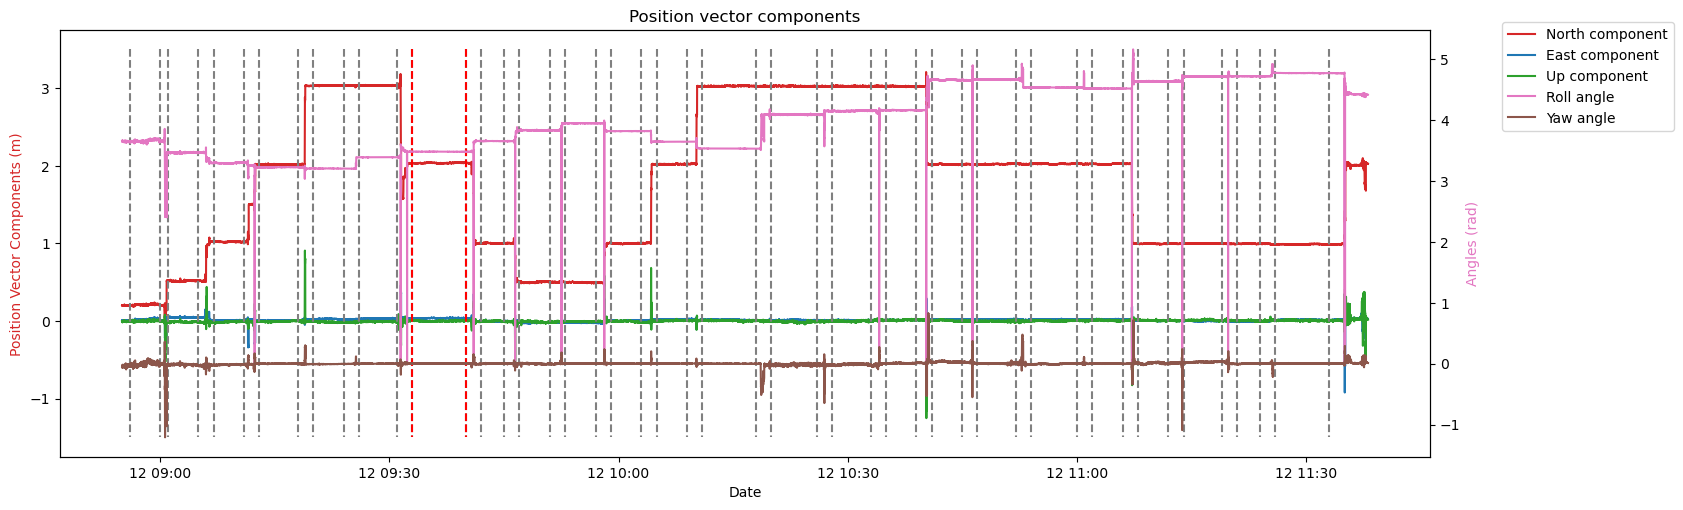

In [7]:
# Plot to verify the previous delimitation
fig, ax1 = plt.subplots(figsize = (15,5))

color_a = 'tab:pink'
color_r = 'tab:red'
color_b = 'tab:blue'
color_d = 'tab:green'
color_c = 'tab:brown'

ax1.set_xlabel('Date')
ax1.set_ylabel('Position Vector Components (m)', color = color_r)
ax1.plot(gps_antenna._datetime[index_ini:], gps_antenna.rpN[index_ini:], color = color_r, label = 'North component')
ax1.plot(gps_antenna._datetime[index_ini:], gps_antenna.rpE[index_ini:], color = color_b, label = 'East component')
ax1.plot(gps_antenna._datetime[index_ini:], gps_antenna.rpD[index_ini:], color = color_d, label = 'Up component')

ax2 = ax1.twinx()

ax2.plot(gps_antenna._datetime[index_ini:], gps_antenna.roll[index_ini:], color = color_a, label = 'Roll angle')
ax2.plot(gps_antenna._datetime[index_ini:], gps_antenna.yaw[index_ini:], color = color_c, label = 'Yaw angle')
ax2.set_xlabel('Date')
ax2.set_ylabel('Angles (rad)', color = color_a)

for obs_index in array_index:
    ax1.vlines(gps_antenna._datetime[obs_index], 3.5, -1.5, 'grey', linestyles='--')
ax1.vlines(gps_antenna._datetime[array_index[6]], 3.5, -1.5, 'r', linestyles='--')
ax1.vlines(gps_antenna._datetime[array_index[6 + int(array_hours.shape[0])]], 3.5, -1.5, 'r', linestyles='--')

fig.tight_layout()
ax1.set_title("Position vector components")
fig.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [8]:
# Function to remove the movement between each configurations
def only_data(array, indices):
    data_array = np.array([])
    
    for i in range(int(indices.shape[0]/2)):
        data_array = np.append(data_array, array[indices[i]:indices[i+int(indices.shape[0]/2)]])
    
    return data_array

In [9]:
data_rpN = only_data(gps_antenna.rpN, array_index)
data_rpE = only_data(gps_antenna.rpE, array_index)
data_rpD = only_data(gps_antenna.rpD, array_index)
data_roll = only_data(gps_antenna.roll, array_index)
data_yaw = only_data(gps_antenna.yaw, array_index)

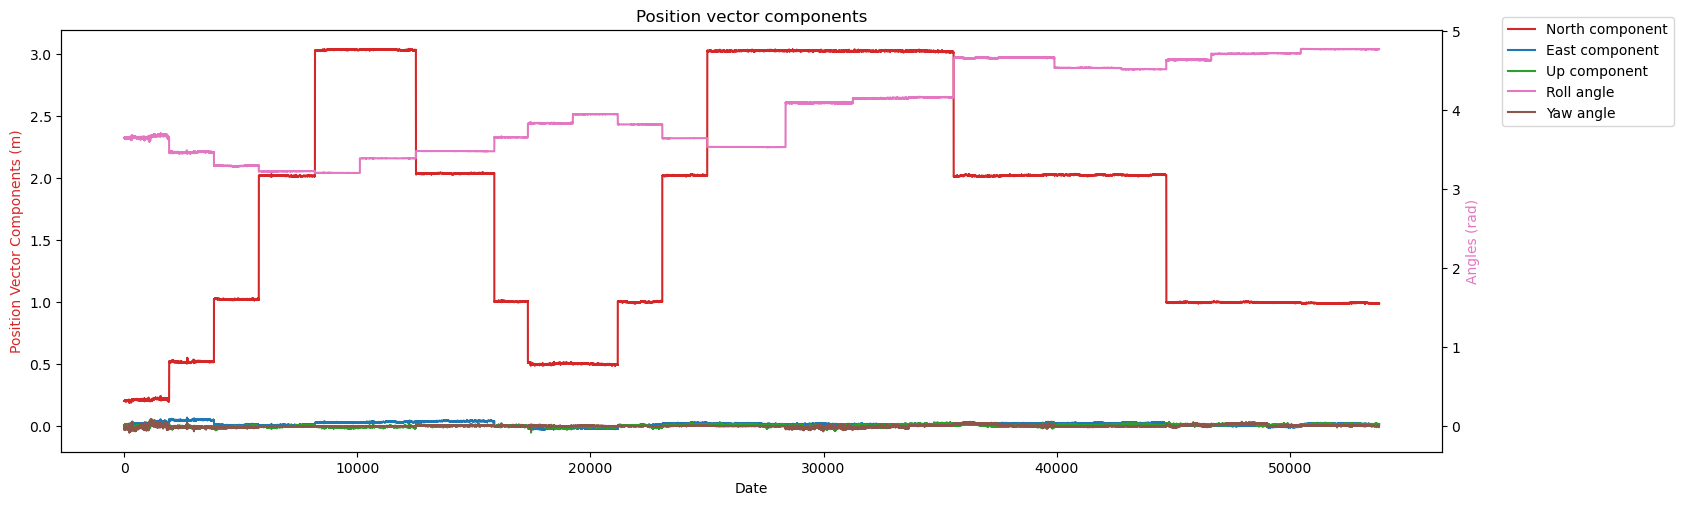

In [10]:
# Plot to verify the filtering of the time when the antennas are moving
fig, ax1 = plt.subplots(figsize = (15,5))

color_a = 'tab:pink'
color_r = 'tab:red'
color_b = 'tab:blue'
color_d = 'tab:green'
color_c = 'tab:brown'

ax1.set_xlabel('Date')
ax1.set_ylabel('Position Vector Components (m)', color = color_r)
ax1.plot(data_rpN, color = color_r, label = 'North component')
ax1.plot(data_rpE, color = color_b, label = 'East component')
ax1.plot(data_rpD, color = color_d, label = 'Up component')

ax2 = ax1.twinx()

ax2.plot(data_roll, color = color_a, label = 'Roll angle')
ax2.plot(data_yaw, color = color_c, label = 'Yaw angle')
ax2.set_xlabel('Date')
ax2.set_ylabel('Angles (rad)', color = color_a)

fig.tight_layout()
ax1.set_title("Position vector components")
fig.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Standard deviation for each configurations

In [11]:
# Function to compute the standard deviation avoiding moments when I changed the experimental configuration
def only_data_std(array, indices):
    data_array = np.array([])
    
    for i in range(int(indices.shape[0]/2)):
        data_array = np.append(data_array, np.std(array[indices[i]:indices[i+int(indices.shape[0]/2)]]))
    
    return data_array

In [12]:
# Multiply by 100 to convert from m to cm
std_rpN = only_data_std(gps_antenna.rpN, array_index) * 100
std_rpE = only_data_std(gps_antenna.rpE, array_index) * 100
std_rpD = only_data_std(gps_antenna.rpD, array_index) * 100
std_roll = np.degrees(only_data_std(gps_antenna.roll, array_index))
std_yaw = np.degrees(only_data_std(gps_antenna.yaw, array_index))

In [13]:
# Distances during test 1
distance_base_antenna1 = np.array([20, 20, 20, 20, 20, 100, 100, 100, 100, 200, 200, 200, 200])
distance_base_antenna2 = np.array([20, 50, 100, 200, 300, 300, 200, 100, 50, 50, 100, 200, 300])

# Distance during test 2
distance_base_antenna2_bis = np.array([300, 300, 300, 200, 200, 200, 200, 100, 100, 100, 100])
distance_antenna1_antenna2 = np.array([50, 100, 200, 50, 100, 200, 300, 50, 100, 200, 300])

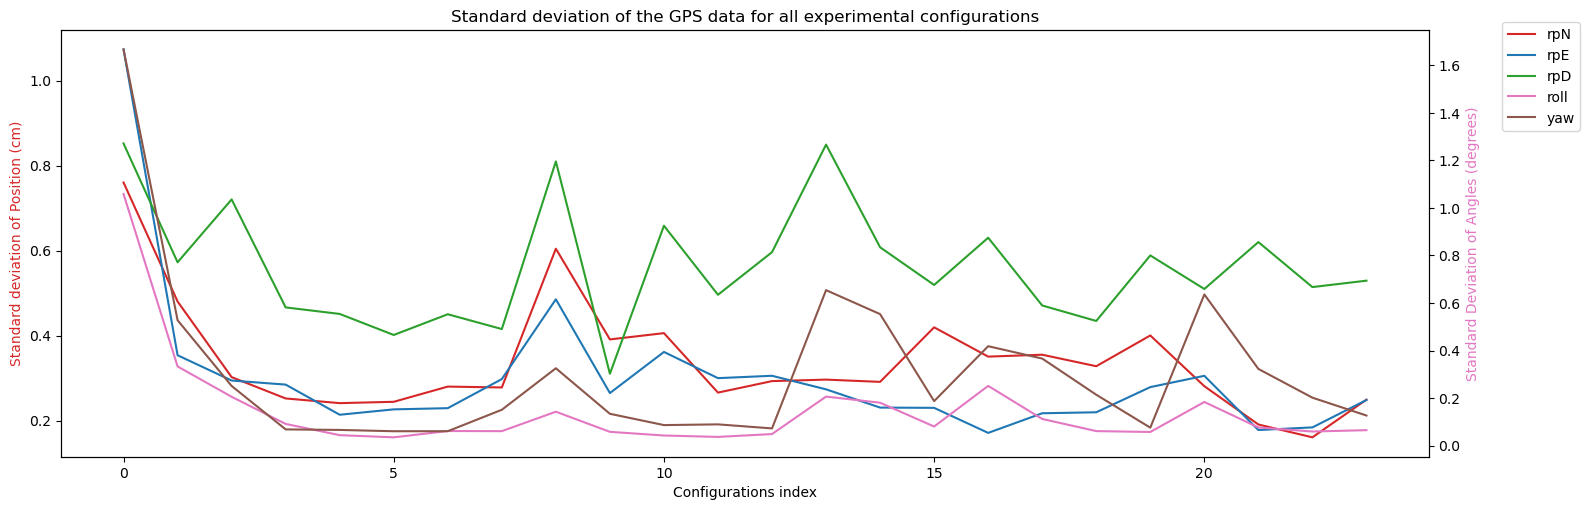

In [14]:
# Plot the standard deviation for each instumental configuration
fig, ax1 = plt.subplots(figsize = (15,5))

color_a = 'tab:pink'
color_r = 'tab:red'
color_b = 'tab:blue'
color_d = 'tab:green'
color_c = 'tab:brown'

ax1.set_xlabel('Configurations index')
ax1.set_ylabel('Standard deviation of Position (cm)', color = color_r)
ax1.plot(std_rpN, label = 'rpN', color=color_r)
ax1.plot(std_rpE, label = 'rpE', color=color_b)
ax1.plot(std_rpD, label = 'rpD', color=color_d)
ax2 = ax1.twinx()

ax2.plot(std_roll, label = 'roll', color=color_a)
ax2.plot(std_yaw, label = 'yaw', color=color_c)
ax2.set_xlabel('Configurations index')
ax2.set_ylabel('Standard Deviation of Angles (degrees)', color = color_a)

fig.tight_layout()
ax1.set_title("Standard deviation of the GPS data for all experimental configurations")
fig.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [15]:
print('Minimum Std Position : ', np.min([std_rpD, std_rpE, std_rpN]).round(2), '(cm), Maximum Std Position : ', np.max([std_rpD, std_rpE, std_rpN]).round(2), '(cm)')
print('Minimum Std Angle : ', np.min([std_roll, std_yaw]).round(2), '(degrees), Maximum Std Angle : ', np.max([std_roll, std_yaw]).round(2), '(degrees)')

Minimum Std Position :  0.16 (cm), Maximum Std Position :  1.07 (cm)
Minimum Std Angle :  0.03 (degrees), Maximum Std Angle :  1.67 (degrees)


## Standard Deviation for Experiment 1

In [16]:
def plot_std_exp1(array, pos=True):
    plt.figure()
    if pos:
        leg = 'cm'
    else:
        leg = 'deg'
    scatter = plt.scatter(distance_base_antenna2, distance_base_antenna1, s=array[:distance_base_antenna1.shape[0]]*100, c=array[:distance_base_antenna1.shape[0]], cmap='viridis')
    plt.colorbar(scatter, label=f'Standard deviation ({leg})')
    plt.xlabel('Distance Base-Antenna 2 (cm)')
    plt.ylabel('Distance Base-Antenna 1 (cm)')

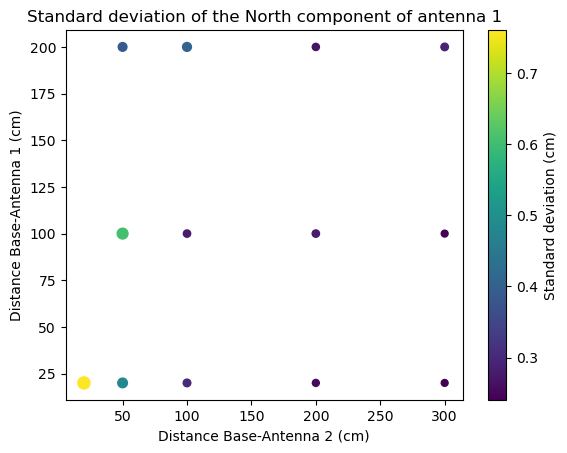

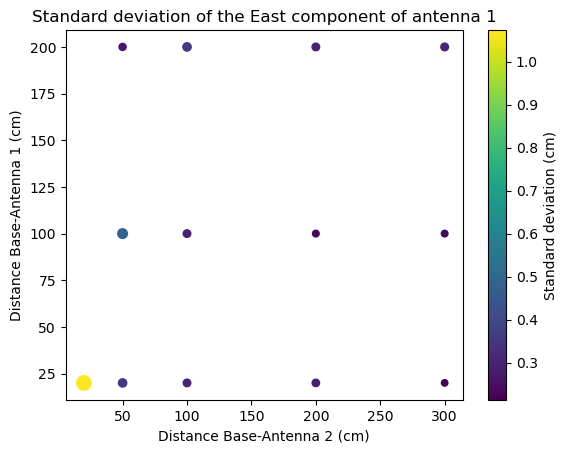

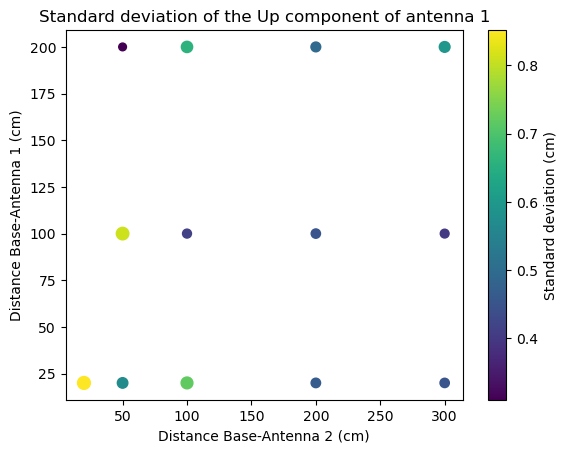

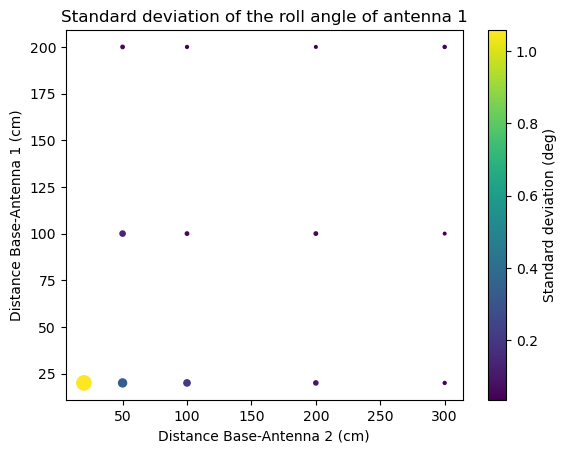

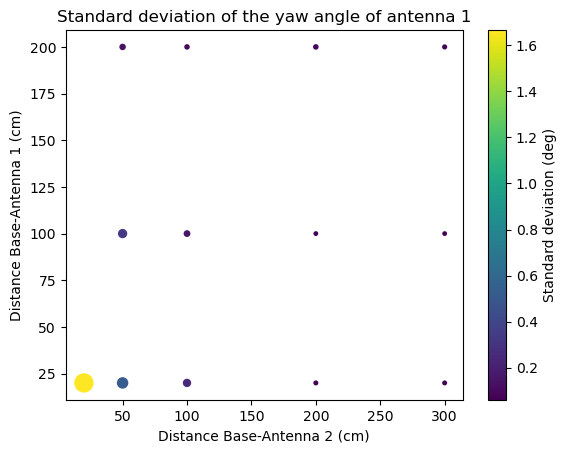

In [17]:
plot_std_exp1(std_rpN)
plt.title('Standard deviation of the North component of antenna 1')
plt.show()
plot_std_exp1(std_rpE)
plt.title('Standard deviation of the East component of antenna 1')
plt.show()
plot_std_exp1(std_rpD)
plt.title('Standard deviation of the Up component of antenna 1')
plt.show()
plot_std_exp1(std_roll, pos=False)
plt.title('Standard deviation of the roll angle of antenna 1')
plt.show()
plot_std_exp1(std_yaw, pos=False)
plt.title('Standard deviation of the yaw angle of antenna 1')
plt.show()

## Standard Deviation for Experiment 2

In [18]:
def plot_std_exp2(array, pos=True):
    if pos:
        leg = 'cm'
    else:
        leg = 'deg'
    scatter = plt.scatter(distance_base_antenna2_bis, distance_antenna1_antenna2, s=array[distance_base_antenna2.shape[0]:]*100, c=array[distance_base_antenna2.shape[0]:], cmap='viridis')
    plt.colorbar(scatter, label=f'Standard deviation ({leg})')
    plt.legend()
    plt.xlabel('Distance Base-Antenna 2 (cm)')
    plt.ylabel('Distance Antenna 1 - Antenna 2')

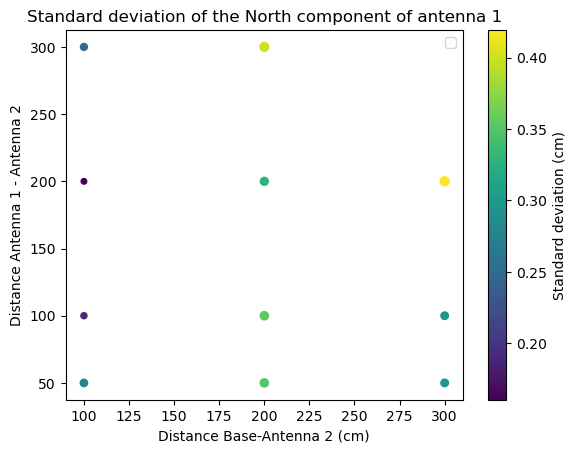

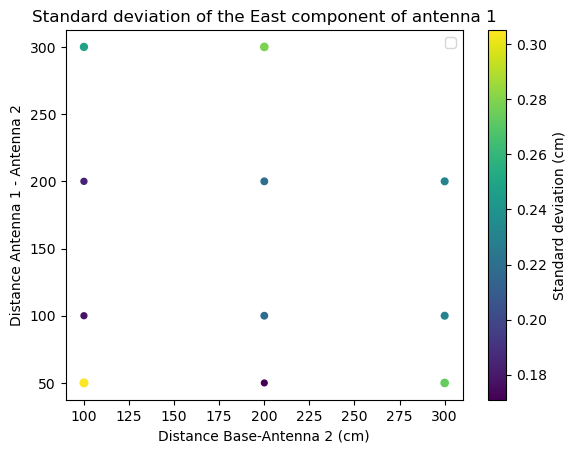

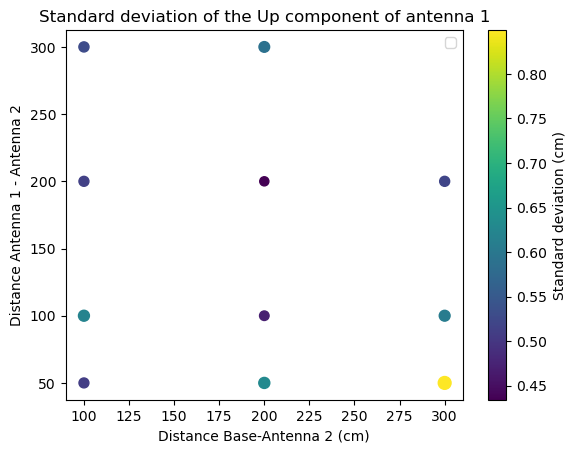

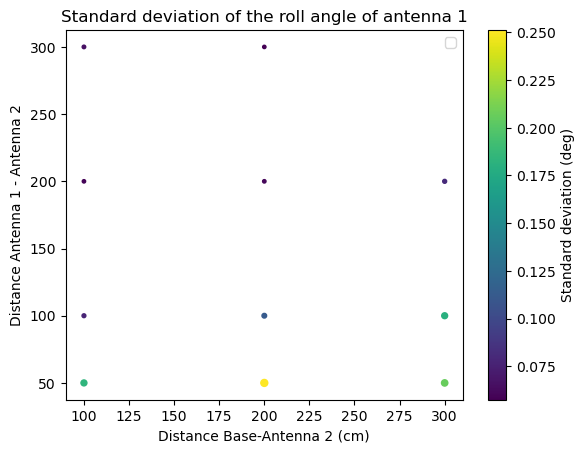

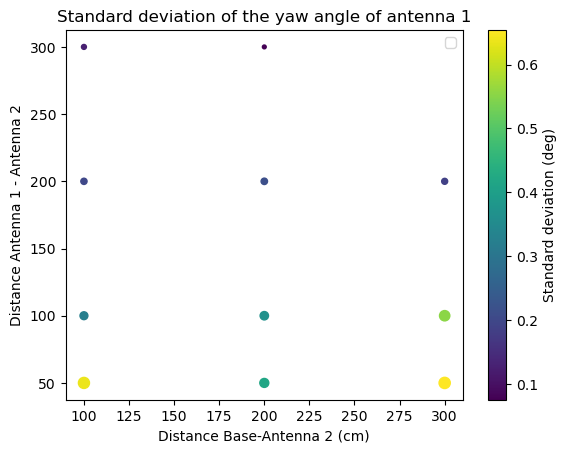

In [19]:
plot_std_exp2(std_rpN)
plt.title('Standard deviation of the North component of antenna 1')
plt.show()
plot_std_exp2(std_rpE)
plt.title('Standard deviation of the East component of antenna 1')
plt.show()
plot_std_exp2(std_rpD)
plt.title('Standard deviation of the Up component of antenna 1')
plt.show()
plot_std_exp2(std_roll, pos=False)
plt.title('Standard deviation of the roll angle of antenna 1')
plt.show()
plot_std_exp2(std_yaw, pos=False)
plt.title('Standard deviation of the yaw angle of antenna 1')
plt.show()

# Incertainty on antenna 1 position

$\Delta r = \sqrt{(\frac{x}{r}\Delta x)^{2} + (\frac{y}{r}\Delta y)^{2} + (\frac{z}{r}\Delta z)^{2}}$

In [20]:
delta_r = np.array([])

for i in range(int(array_index.shape[0]/2)):
    data_array_north = np.mean(gps_antenna.rpN[array_index[i]:array_index[i+int(array_index.shape[0]/2)]] )
    data_array_east = np.mean(gps_antenna.rpE[array_index[i]:array_index[i+int(array_index.shape[0]/2)]] )
    data_array_down = np.mean(gps_antenna.rpD[array_index[i]:array_index[i+int(array_index.shape[0]/2)]])

    # Don't forget to convert from m to cm
    std_north = np.std(gps_antenna.rpN[array_index[i]:array_index[i+int(array_index.shape[0]/2)]]) * 100
    std_east = np.std(gps_antenna.rpE[array_index[i]:array_index[i+int(array_index.shape[0]/2)]]) * 100
    std_down = np.std(gps_antenna.rpD[array_index[i]:array_index[i+int(array_index.shape[0]/2)]]) * 100

    r = np.sqrt(data_array_north**2 + data_array_east**2 + data_array_down**2)

    delta_r = np.append(delta_r, np.sqrt((data_array_north * std_north / r)**2 + 
                                         (data_array_east * std_east / r)**2 + 
                                         (data_array_down * std_down / r)**2))
print(delta_r.shape)

(24,)


Text(0.5, 1.0, 'Relative error on the position of the antenna 1 during experiment 1')

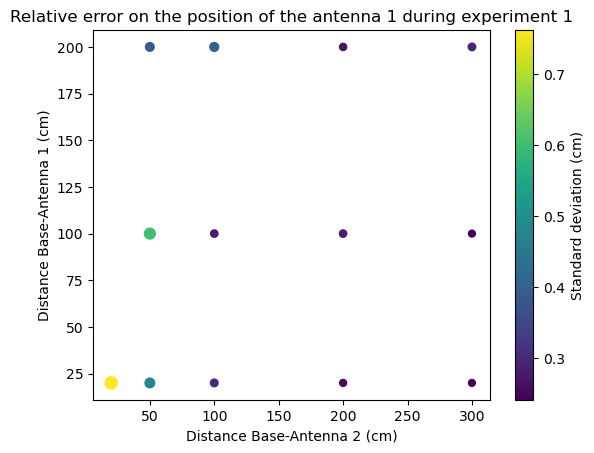

In [21]:
plt.figure()
scatter = plt.scatter(distance_base_antenna2, distance_base_antenna1, s=delta_r[:distance_base_antenna1.shape[0]]*100, c=delta_r[:distance_base_antenna1.shape[0]], cmap='viridis')
plt.colorbar(scatter, label='Standard deviation (cm)')
plt.xlabel('Distance Base-Antenna 2 (cm)')
plt.ylabel('Distance Base-Antenna 1 (cm)')
plt.title('Relative error on the position of the antenna 1 during experiment 1')

# Define function to make plot using Delaunay triangulation

In [22]:
def delaunay_surface_plot(x, y, z, title, xtitle, ytitle, ztitle, save=False):
    tri = Delaunay(np.array([x, y]).T)
    simplices = tri.simplices

    fig = ff.create_trisurf(x=x, y=y, z=z,
                                simplices=simplices, title=dict(text=title, font=dict(size=24)))
    fig.update_layout(scene = dict(xaxis_title=xtitle,
                                yaxis_title=ytitle,
                                zaxis_title=ztitle),
                                )
    if save:
        fig.write_html('plotly/plotly.html')
    fig.show()

# Experiment 1

## Position Antenna 1

In [23]:
# Experiment 1
delaunay_surface_plot(distance_base_antenna1, distance_base_antenna2, delta_r[:distance_base_antenna1.shape[0]], 
                      'Relative error on the position of the antenna 1 during experiment 1',
                      'Distance Base-Antenna 1 (cm)',
                      'Distance Base-Antenna 2 (cm)',
                      'Standard Deviation (cm)', save=False)

## GPS Data

In [24]:
idx = -1
std_data = np.array([std_rpN, std_rpE, std_rpD, std_roll, std_yaw])
names = np.array(['North', 'East', 'Down', 'Roll', 'Yaw'])

delaunay_surface_plot(distance_base_antenna1, distance_base_antenna2, std_data[idx][:distance_base_antenna1.shape[0]], 
                      f'Relative error on {names[idx]} Component during experiment 1',
                      'Distance Base-Antenna 1 (cm)',
                      'Distance Base-Antenna 2 (cm)',
                      'Standard Deviation (cm)')

# Experiment 2

## Position Antenna 1

In [25]:
# Experiment 2
delaunay_surface_plot(distance_antenna1_antenna2, distance_base_antenna2_bis, delta_r[distance_base_antenna2.shape[0]:],
                      'Relative error on the position of the antenna 1 during experiment 2',
                      'Distance Antenna 1 - Antenna 2 (cm)',
                      'Distance Base-Antenna 2 (cm)',
                      'Standard Deviation (cm)', save=False)

## GPS Data

In [ ]:
idx = -1
std_data = np.array([std_rpN, std_rpE, std_rpD, std_roll, std_yaw])
names = np.array(['North', 'East', 'Down', 'Roll', 'Yaw'])

delaunay_surface_plot(distance_antenna1_antenna2, distance_base_antenna2_bis, std_data[idx][distance_base_antenna1.shape[0]:], 
                      f'Relative error on {names[idx]} Component during experiment 2',
                      'Distance Antenna 1 - Antenna 2 (cm)',
                      'Distance Base-Antenna 2 (cm)',
                      'Standard Deviation (cm)')

# Noise Power Spectrum

## Def useful functions

In [27]:
timestep = (gps_antenna._datetime[1] - gps_antenna._datetime[0]).microseconds * 1e-6
print("Timestep : ", timestep, "s.")

def get_ps(array):
    """Function to compute the power spectrum of a given array.

    Parameters
    ----------
    array : array_like
        array containing the data to compute the power spectrum of.

    Returns
    -------
    power_spectrum : array_like
        array containing the power spectrum of the input array.
    freq: array_like
        array containing the frequency of the power spectrum.
    """
    N = array.size
    return np.abs(np.fft.rfft(array))**2, np.fft.rfftfreq(N, d=timestep/2)

Timestep :  0.125 s.


Text(0.5, 1.0, 'Noise Power Spectrum - North')

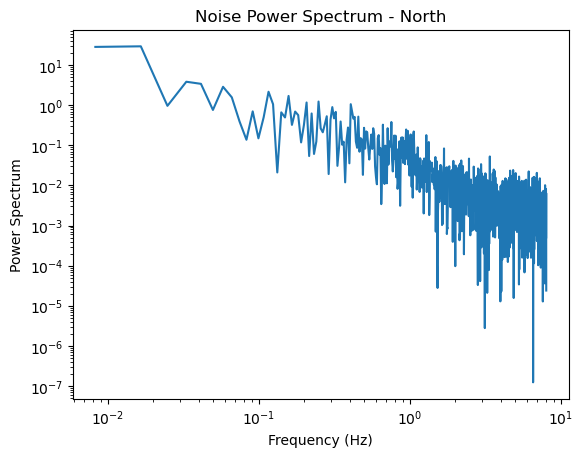

In [28]:
power_spectrum, freq = get_ps(gps_antenna.rpN[array_index[0]:array_index[int(array_index.size/2)]])
power_spectrum, freq = power_spectrum[1:], freq[1:]

plt.plot(freq, power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')
plt.xscale('log')
plt.yscale('log')
plt.title('Noise Power Spectrum - North')

In [29]:
def fit_ps(data, name, nbins=20, range=None, plot=False, return_=False, print_=False):
    power_spectrum, freq = get_ps(data)
    power_spectrum, freq = power_spectrum[1:], freq[1:]

    # Fit a line to the logarithm of the power spectrum
    res = linregress(np.log(freq), np.log(power_spectrum))
    slope, intercept, std_err = res.slope, res.intercept, res.stderr
    
    # Create bins for the power spectrum. Allows to understand the fitted line
    xx, yy, dx, dy, _ = ft.profile(np.log(freq), np.log(power_spectrum), nbins=nbins, plot=False, rng=range)
    res_bin = linregress(xx, yy)
    slope_bin, intercept_bin, std_err_bin = res_bin.slope, res_bin.intercept, res_bin.stderr

    if print_:
        print(f"Slope: {slope:.2f} " + "\u00B1" + f' {std_err:.2f}')

    if plot:
        # Plot the power spectrum and the fit
        plt.figure(figsize=(8, 6))
        plt.scatter(np.log(freq), np.log(power_spectrum), s=1, color='blue', alpha = 0.5, label='Power Spectrum')
        plt.errorbar(xx, yy, xerr=dx, yerr=dy, fmt='ro', label='Binning of the noise power spectrum')
        plt.plot(np.log(freq), slope * np.log(freq) + intercept, color='blue', label=f'Fit Power Spectrum - Slope: {slope:.2f} ' + "\u00B1" + f' {std_err:.2f}')
        
        plt.plot(np.log(freq), slope_bin * np.log(freq) + intercept_bin, color='red', label=f'Fit binned Power Spectrum - Slope: {slope_bin:.2f} ' + "\u00B1" + f' {std_err_bin:.2f}')


        plt.xlabel('Log(k)')
        plt.ylabel('Log(P(k))')
        plt.title('GPS Noise Power Spectrum - ' + name)
        plt.legend()
        plt.grid(True)
        plt.show()

    if return_:
        return slope_bin

## Fit 1/f noise with curve_fit

### Fit on all configurations

In this section, I compute the power spectrum for all experimental configurations at same time, and then compute the associated slope for each GPS Data.

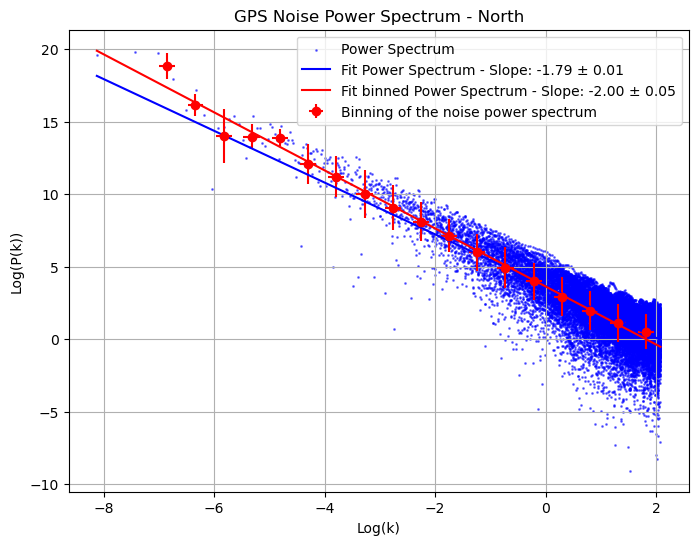

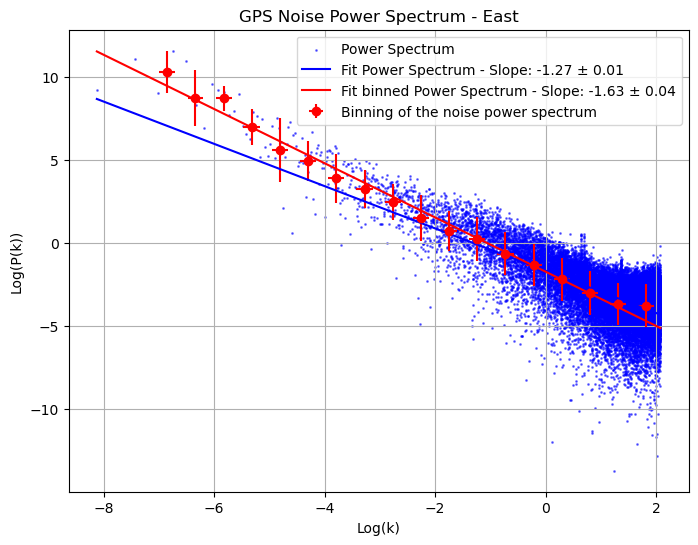

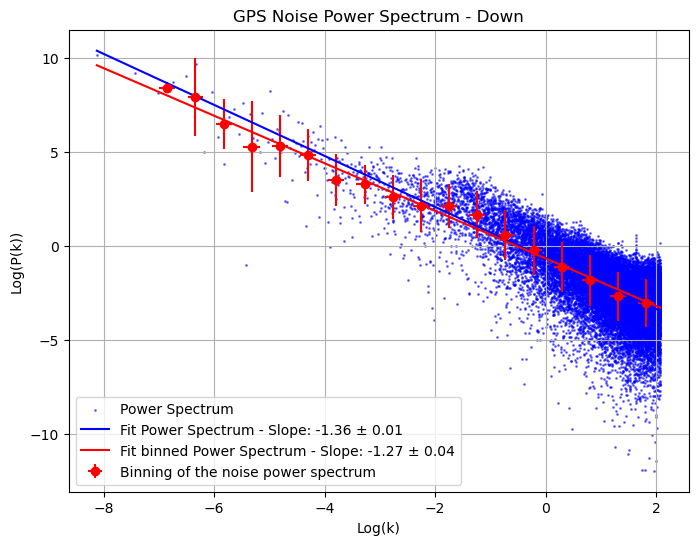

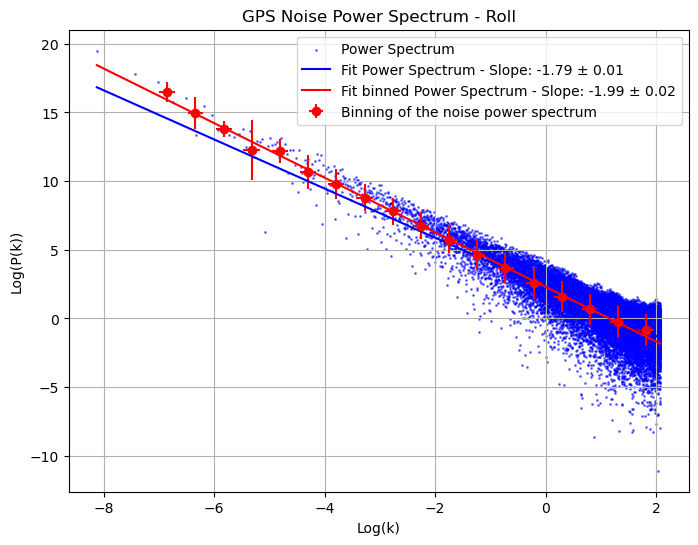

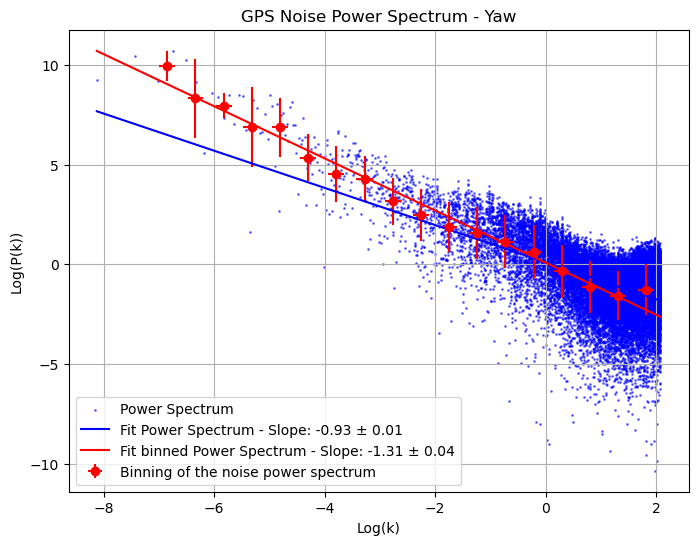

In [30]:
gps_data = np.array([data_rpN, data_rpE, data_rpD, data_roll, data_yaw])
names = np.array(['North', 'East', 'Down', 'Roll', 'Yaw'])

for idx, name in enumerate(names):
    fit_ps(gps_data[idx], name, nbins=20, plot=True)

### Fit for each configurations

In this section, I compute the power spectrum for each experimental configurations, and then compute the mean slope for each GPS Data.

In [31]:
def slope_each_config(data, name):
    slope_list = []
    for i in range(int(array_index.shape[0]/2)):
        data_array = data[array_index[i]:array_index[i+int(array_index.shape[0]/2)]]
        slope = fit_ps(data_array, name, nbins=20, return_=True)
        slope_list.append(slope)
    return np.array(slope_list)

Text(0.5, 1.0, 'Power Spectrum slope evolution - Yaw')

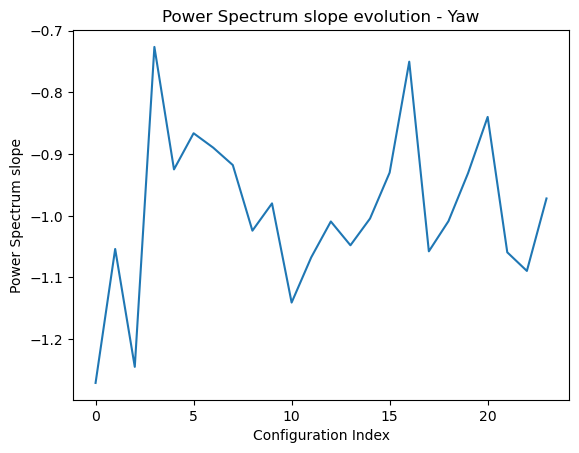

In [32]:
data, name = gps_antenna.yaw, "Yaw"

rpN_slopes = slope_each_config(data, name)
plt.plot(rpN_slopes)
plt.xlabel("Configuration Index")
plt.ylabel("Power Spectrum slope")
plt.title(f"Power Spectrum slope evolution - {name}")

In [33]:
data_gps = np.array([gps_antenna.rpN, gps_antenna.rpE, gps_antenna.rpD, gps_antenna.roll, gps_antenna.yaw])

for i,data in enumerate(data_gps):
    print(f'The mean slope for {names[i]} is : ', np.mean(slope_each_config(data, names[i])).round(2), "\u00B1", np.std(slope_each_config(data, names[i])).round(2))

The mean slope for North is :  -1.22 ± 0.14
The mean slope for East is :  -1.13 ± 0.18
The mean slope for Down is :  -1.27 ± 0.17
The mean slope for Roll is :  -0.91 ± 0.23
The mean slope for Yaw is :  -0.99 ± 0.13


## Fit more advanced noise model

$P_{noise}(f) = A_{white}^2 (1 + |f_{knee}/f|^{\alpha})$

In [34]:
def noise_1_over_f(x, slope):
    return (1/x)**slope

def noise_model(x, A, f_knee, slope):
    return A**2 * (1 + np.abs(f_knee/x)**slope)

In [35]:
def fit_noise_model(data, name, plot=False, _return=False, _print=False):
    power_spectrum, freq = get_ps(data)
    power_spectrum, freq = power_spectrum[1:], freq[1:]

    params, err = curve_fit(noise_model, freq, power_spectrum, maxfev=10000)#, bounds=([0, 0, 0], [1e10, 1e10, 10]))

    if plot:
        plt.plot(freq, power_spectrum, label='Data')
        plt.plot(freq, noise_model(freq, *params), label='Fit')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectrum')
        plt.title(f'Noise Model Fit for {name}')
        plt.legend()
        plt.show()
    
    if _print:
        print(f"Noise model parameters for {name}: A = ", params[0].round(2), "\u00B1", err[0, 0].round(2), 
              "f_knee = ", params[1].round(2), "\u00B1", err[1, 1].round(2), 
              "slope = ", params[2].round(2), "\u00B1", err[2, 2].round(2))

    if _return:
        return params, err
    
def fit_noise_model_all(data, name, plot=False, _print=False):
    params = []
    errors = []
    for i in range(int(array_index.size/2)):
        param, err = fit_noise_model(data[array_index[i]:array_index[i + int(array_index.size/2)]], name, plot, _return=True, _print=_print)
        params.append(param)
        errors.append(err)
    return np.array(params), np.array(errors) 

In [36]:
params, errors = fit_noise_model_all(gps_antenna.rpN, 'North', _print=True)

Noise model parameters for North: A =  0.0 ± 6.21 f_knee =  1064.42 ± 1060874671333.59 slope =  1.23 ± 0.0
Noise model parameters for North: A =  0.12 ± 0.0 f_knee =  1.06 ± 0.06 slope =  1.36 ± 0.0
Noise model parameters for North: A =  0.0 ± 5.48 f_knee =  176363.51 ± 1.0279970395325838e+18 slope =  0.88 ± 0.0
Noise model parameters for North: A =  0.09 ± 0.0 f_knee =  0.04 ± 0.0 slope =  3.6 ± 0.01
Noise model parameters for North: A =  0.05 ± 0.0 f_knee =  0.49 ± 0.01 slope =  1.78 ± 0.0
Noise model parameters for North: A =  0.07 ± 0.0 f_knee =  0.39 ± 0.0 slope =  1.68 ± 0.0
Noise model parameters for North: A =  0.0 ± 10.17 f_knee =  81137.38 ± 8.775492252127968e+16 slope =  0.86 ± 0.0
Noise model parameters for North: A =  0.06 ± 0.0 f_knee =  0.16 ± 0.0 slope =  2.6 ± 0.0
Noise model parameters for North: A =  0.14 ± 0.0 f_knee =  0.05 ± 0.0 slope =  4.27 ± 0.0
Noise model parameters for North: A =  0.09 ± 0.0 f_knee =  0.29 ± 0.0 slope =  2.09 ± 0.0
Noise model parameters for

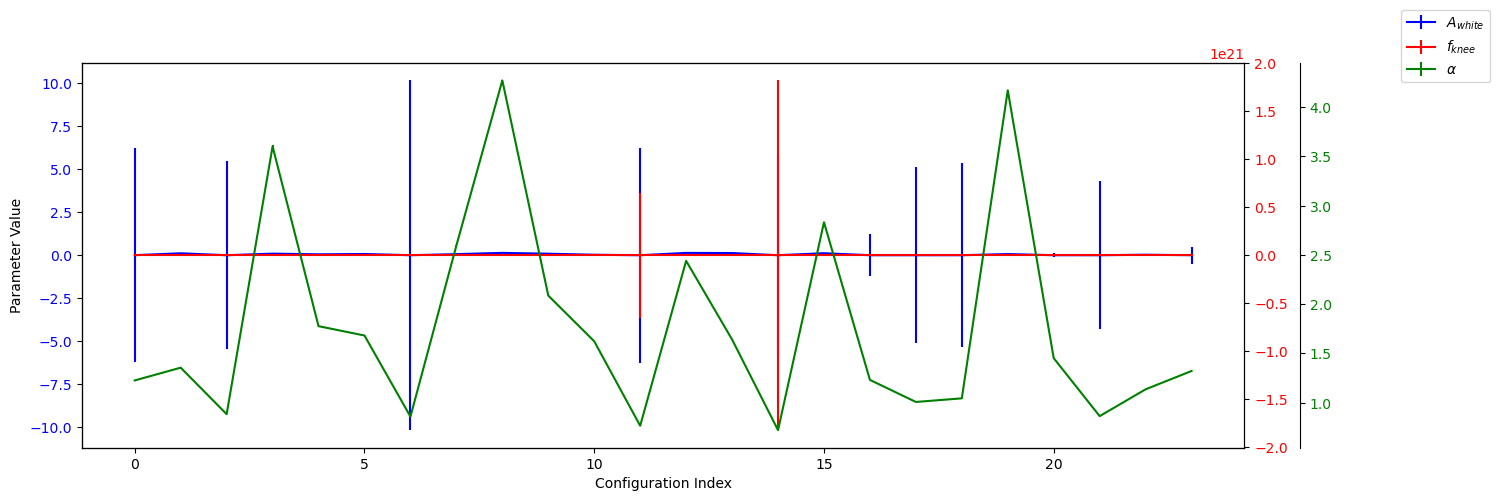

In [37]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1plot = plt.errorbar(np.arange(0, 24), params[:, 0], yerr=errors[:, 0, 0], label=r"$A_{white}$", color='b')
ax2 = ax1.twinx()
ax2plot = plt.errorbar(np.arange(0, 24), params[:, 1], yerr=errors[:, 1, 1], label=r"$f_{knee}$", color='r')
ax3 = ax1.twinx()
ax3plot = plt.errorbar(np.arange(0, 24), params[:, 2], yerr=errors[:, 2, 2], label=r"$\alpha$", color='g')
ax3.spines["right"].set_position(("outward", 40))  
fig.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_xlabel('Configuration Index')
ax1.set_ylabel('Parameter Value')
ax1.tick_params(axis="y", labelcolor="b")
ax2.tick_params(axis="y", labelcolor="r")
ax3.tick_params(axis="y", labelcolor="green")

Removed no burn in


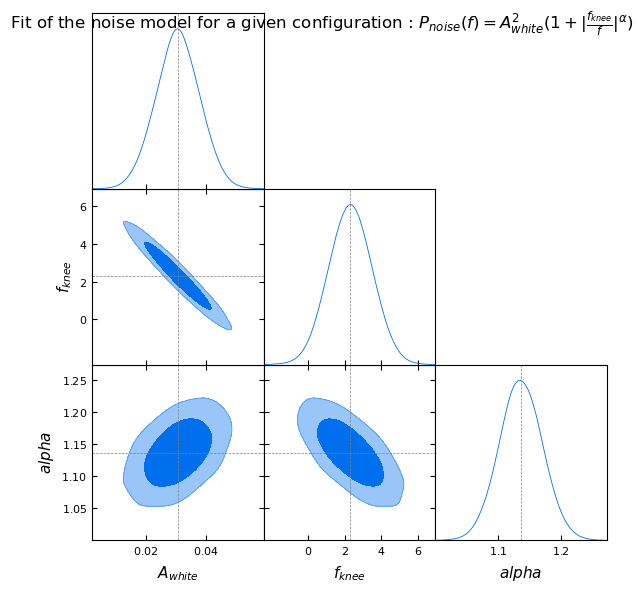

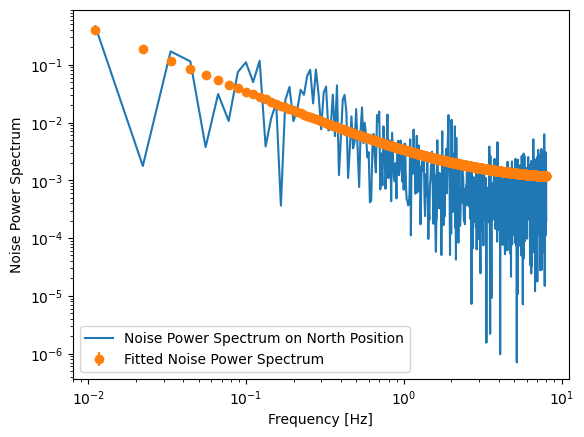

In [38]:
index = 22
# Triangle plot
from getdist import plots, MCSamples
n_samples = 10000
samples = np.random.multivariate_normal(mean=params[index], cov=errors[index], size=n_samples)

param_names = ["A_{white}", "f_{knee}", "alpha"]  
mcsamples = MCSamples(samples=samples, names=param_names, labels=param_names)

g = plots.get_subplot_plotter()
g.triangle_plot(mcsamples, filled=True, markers={"A_{white}":params[index, 0], "f_{knee}":params[index, 1], "alpha":params[index, 2]})
plt.suptitle(r"Fit of the noise model for a given configuration : $P_{noise}(f) = A_{white}^2 (1 + |\frac{f_{knee}}{f}|^{\alpha})$")

# Fit plot
plt.figure()
ps_test, freq_test = get_ps(gps_antenna.rpN[array_index[index]:array_index[index+(int(array_index.size/2))]])
freq_test, ps_test = freq_test[1:], ps_test[1:]
plt.plot(freq_test, ps_test, label="Noise Power Spectrum on North Position")
plt.errorbar(freq_test, noise_model(freq_test, params[index, 0], params[index, 1], params[index, 2]), 
             yerr=noise_model(freq_test, errors[index, 0, 0], errors[index, 1, 1], errors[index, 2, 2]), 
             fmt="o", label="Fitted Noise Power Spectrum")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise Power Spectrum")
plt.xscale("log")
plt.yscale("log")

## Fit noise 1/f with MCMC

In [39]:
def get_power_spectrum(data):
    power_spectrum, freq = get_ps(data)
    power_spectrum, freq = power_spectrum[1:], freq[1:]

    # Create bins for the power spectrum. Allows to understand the fitted line
    freq, power_spectrum, dx, dy, _ = ft.profile(np.log(freq), np.log(power_spectrum), nbins=20, plot=False)
    
    return power_spectrum, freq, dy

In [40]:
def noise_one_over_f(params, x):
    alpha = params[0]
    return (1/x)**alpha

def noise_model(params, x):
    A, f_knee, slope = params
    return A**2 * (1 + np.abs(f_knee/x)**slope)

In [41]:
def log_likelihood(params, x, y, yerr):
    model_y = noise_one_over_f(params, x)
    return -0.5 * np.sum(((y - model_y) / yerr) ** 2)

def log_prior_over_f(params):
    alpha = params[0]
    if 0 < alpha:
        return 0.0
    else:
        return -np.inf

def log_prior(params):
    A, f_knee, slope = params
    if 0 < A and 0 < f_knee and 0 < slope:
        return 0.0  
    return -np.inf 

def log_posterior(params, x, y, yerr):
    lp = log_prior_over_f(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

In [42]:
ndim = 1
nwalkers = 50  
nsteps = 500  
initial = [10 + 0.5e1 * np.random.randn(ndim) for _ in range(nwalkers)]  

In [43]:
index=0
ps, freq, pserr = get_power_spectrum(gps_antenna.rpN[array_index[index]:array_index[index+(int(array_index.size/2))]])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(freq, ps, pserr))
sampler.run_mcmc(initial, nsteps, progress=True)

ValueError: Probability function returned NaN

In [ ]:
samples = sampler.get_chain(flat=True)  
A_samples, f_knee_samples, alpha_samples = samples[:, 0], samples[:, 1], samples[:, 2]

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
param_names = ["A_{white}", "f_{knee}", "alpha"]  
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[..., i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [ ]:
mcsamples = MCSamples(samples=samples, names=param_names, labels=param_names)

g = plots.get_subplot_plotter()
g.triangle_plot(mcsamples, filled=True, markers={"A_{white}":params[index, 0], "f_{knee}":params[index, 1], "alpha":params[index, 2]})
plt.suptitle(r"Fit of the noise model for a given configuration : $P_{noise}(f) = A_{white}^2 (1 + |\frac{f_{knee}}{f}|^{\alpha})$")

A_est, f_knee_est, alpha_est = np.median(A_samples), np.median(f_knee_samples), np.median(alpha_samples)
print(r"Parameters estimations : $A_{white}$ = ", A_est.round(2), r"$f_{knee}$ = ", f_knee_est.round(2), r"$\alpha$ = ", alpha_est.round(2))

In [ ]:
print(type(int(8000/3)))
print(type(8000//3))